# Data Exploration for SciFact

This notebook presents data exploration for the **SciFact** dataset, incuding:
- Count and join sentences in abstracts
- Text statistics
    - Number of characters, words, and word length
    - Frequency of English stopwords and non-stopwords
- n-gram frequency
- Topic modeling
- Wordcloud
- Sentiment analyis
    - TextBlob
    - VADER
- Named entity recognition (NER)
- Parts of speech tagging (POS)
- Text complexity
- Key takeaways

This notebook was prepared by Jeffrey Dick on 2024-12-14.

- Most sections of this notebook between **Text statistics** and **Text complexity** were modified from [Exploratory Data Analysis for Natural Language Processing: A Complete Guide to Python Tools](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools) by [Shahul ES on neptune.ai](https://neptune.ai/blog/author/shahules).
- **NOTE:** The dataset analyzed in that post is news headlines; certain techniques (such as sentiment analysis) may not be as applicable to scientific abstracts.
- The code in the **Clean abstracts** abstracts section was modified from [What is Topic Modeling? An Introduction With Examples](https://www.datacamp.com/tutorial/what-is-topic-modeling).

Let's load the data and take a look at the first few abstracts.

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 100)

scifact_corpus = pd.read_json('../data/scifact/corpus.jsonl', lines=True)
scifact_corpus.head()

,doc_id,title,abstract,structured
0,4983,Microstructural development of human newborn cerebral white matter assessed in vivo by diffusion...,[Alterations of the architecture of cerebral white matter in the developing human brain can affe...,False
1,5836,Induction of myelodysplasia by myeloid-derived suppressor cells.,[Myelodysplastic syndromes (MDS) are age-dependent stem cell malignancies that share biological ...,False
2,7912,"BC1 RNA, the transcript from a master gene for ID element amplification, is able to prime its ow...",[ID elements are short interspersed elements (SINEs) found in high copy number in many rodent ge...,False
3,18670,The DNA Methylome of Human Peripheral Blood Mononuclear Cells,"[DNA methylation plays an important role in biological processes in human health and disease., R...",False
4,19238,The human myelin basic protein gene is included within a 179-kilobase transcription unit: expres...,[Two human Golli (for gene expressed in the oligodendrocyte lineage)-MBP (for myelin basic prote...,False


## Count and join sentences in abstracts

In [2]:
import numpy as np
from collections import Counter

abstract_length = scifact_corpus['abstract'].apply(len)
abstract_length_counts = Counter(abstract_length)
print("Minimum number of sentences is "+str(np.min(list(abstract_length_counts.keys()))))
abstract_length_counts

Minimum number of sentences is 3


Counter({7: 702,
         8: 639,
         6: 637,
         9: 563,
         5: 468,
         10: 454,
         11: 389,
         12: 269,
         4: 257,
         13: 208,
         3: 134,
         14: 133,
         15: 109,
         16: 71,
         17: 40,
         18: 37,
         20: 19,
         19: 18,
         22: 6,
         21: 5,
         24: 5,
         23: 4,
         42: 3,
         25: 2,
         35: 1,
         41: 1,
         26: 1,
         58: 1,
         335: 1,
         73: 1,
         169: 1,
         27: 1,
         30: 1,
         29: 1,
         367: 1})

Most abstracts have betweeen 3-15 sentences, while some are much longer. Let's see what the long ones look like.

In [3]:
scifact_corpus['abstract'][abstract_length > 50]

1834    [Placebo-controlled trials are used extensively in the development of new pharmaceuticals., They...
2022    [PHENYLALANINE TOXICITY 158 Developing the 0., -M ethylphenylalanine Model. . . . . ., .. ., ., ...
3866    [The U.S. Preventive Services Task Force (USPSTF) makes recommendations about the effectiveness ...
4493    [INTRODUCTION • • CELLULAR AND MOLECULAR REQUIREMENTS FOR T-CELL ACTIVATION ., The T-Cell Antige...
5118    [INTRODUCTION . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .. . . ....
Name: abstract, dtype: object

Some of the abstracts have long sequences of periods (.), which explains the high sentence count.
Let's remove abstracts with more than 20 sentences.
Then we can visualize the numbers of sentences for the remaining abstracts.

<Axes: >

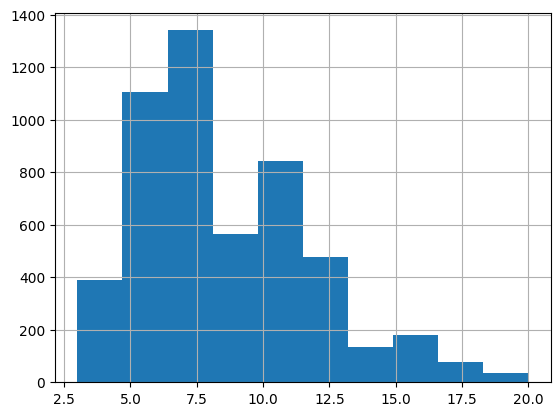

In [4]:
scifact_corpus = scifact_corpus[abstract_length <= 20]
scifact_corpus['abstract'].apply(len).hist()

Let's join the sentences in each abstract for further data exploration.

In [5]:
abstracts = scifact_corpus['abstract'].str.join(' ')

## Text statistics

Plot the number of characters in each abstract.

<Axes: >

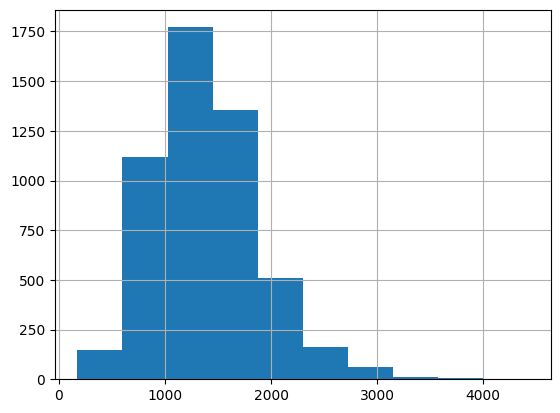

In [6]:
abstracts.str.len().hist()

Plot the number of words in each abstract.

<Axes: >

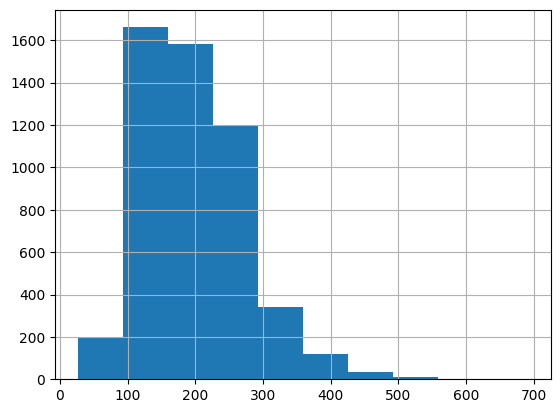

In [7]:
abstracts.str.split(). \
    map(lambda x: len(x)). \
    hist()

Plot the average word length in each abstract.

<Axes: >

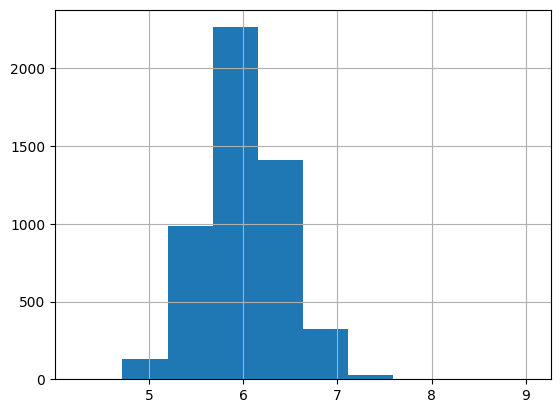

In [8]:
import numpy as np

abstracts.str.split(). \
   apply(lambda x: [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

Get English stopwords from NLTK.

In [9]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jedick/.local/lib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Create the corpus (a single list of words in all abstracts) and count the stopwords.

In [10]:
wordlists = abstracts.str.split().tolist()
corpus = [word for words in wordlists for word in words]

from collections import defaultdict
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

Plot the most frequent stopwords.

<BarContainer object of 10 artists>

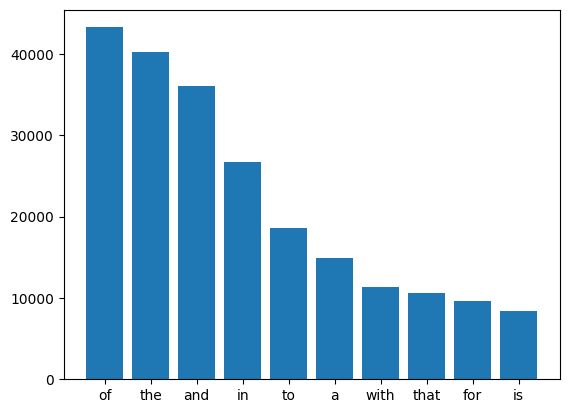

In [11]:
import matplotlib.pyplot as plt

top = sorted(dic.items(), key = lambda x:x[1], reverse = True)[:10] 
x, y = zip(*top)
plt.bar(x, y)

Plot the most frequent words that are not stopwords.

<Axes: >

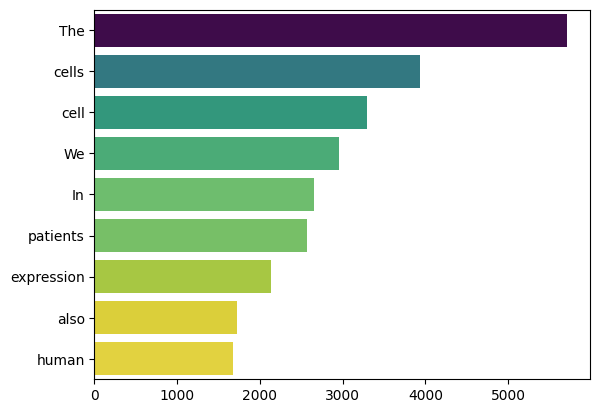

In [12]:
import seaborn as sns
from collections import  Counter

counter = Counter(corpus)
most = counter.most_common()

x, y = [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

# https://stackoverflow.com/questions/63573723/how-to-reverse-the-palette-of-a-seaborn-scatterplot
viridis_rev = plt.get_cmap('viridis').reversed()
sns.barplot(x=y, y=x, palette=viridis_rev, hue=y, legend=False)

It looks like capitalized words such as "The", "We", and "In" need to be lowercased to be recognized as stopwords.

## Clean abstracts

Here we lowercase and remove the stopwords as well as remove punctuation.
Although a lemmatization step is provided, it is skipped in order to reveal actual n-grams.

In [13]:
# Code source: https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

import string
import nltk
nltk.download('stopwords')
#nltk.download('wordnet')

from nltk.corpus import stopwords
#from nltk.stem.wordnet import WordNetLemmatizer

# remove stopwords, punctuation, and normalize the corpus
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
#lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = "".join(ch for ch in stop_free if ch not in exclude)
    return punc_free
    #normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    #return normalized

clean_abstracts = [clean(doc) for doc in abstracts]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jedick/.local/lib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## n-grams

Plot the most frequent bigrams in the abstracts.

<Axes: >

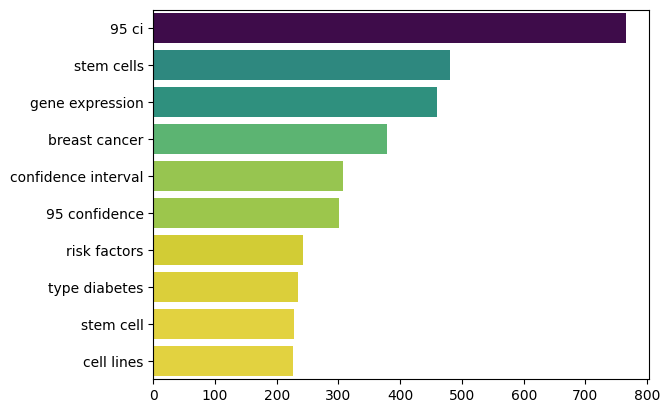

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:10]

top_n_bigrams = get_top_ngram(clean_abstracts, 2)[:10]
x, y = map(list, zip(*top_n_bigrams))
sns.barplot(x=y, y=x, palette=viridis_rev, hue=y, legend=False) 

Plot the most frequent trigrams.

<Axes: >

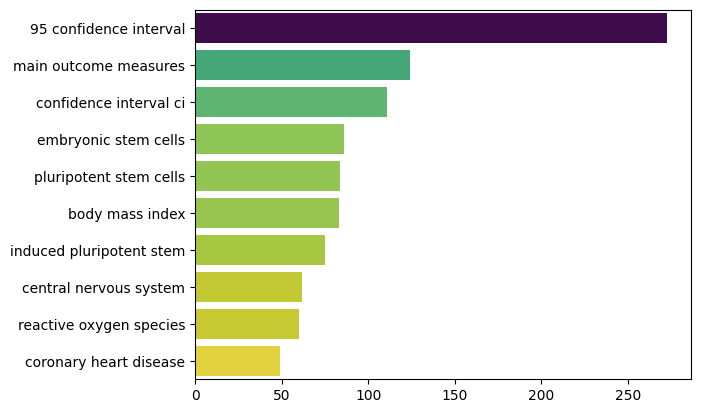

In [15]:
top_tri_grams = get_top_ngram(clean_abstracts, n=3)
x, y = map(list,zip(*top_tri_grams))
sns.barplot(x=y, y=x, palette=viridis_rev, hue=y, legend=False)

## Topic modeling

Topic modeling uses unsupervised learning techniques to extract the main topics in a collection of documents.

Latent Dirichlet Allocation (LDA) is a Bayesian method for topic modeling.
Each document is mapped to a list of topics and each topic is assigned to a different topic.
LDA uses bag of words (BOW), so word order is not important.

Preprocessing the data for LDA includes removing stopwords tokenization, removing stopwords, lemmatization, and bag of words.

- *removing stopwords*: this uses .lower() to remove capitalized stopwords
- *tokenization*: converting the text to a list of tokens (words or parts of words)
- *lemmatization*: grouping the inflected forms of a word to treat them as a single word
- *bag of words*: creates a dictionary with tokens as keys are tokens and frequency of occurrence as values

This code implements the first three steps using NLTK:

In [16]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def preprocess_text(abstracts):
    corpus = []
    lem = WordNetLemmatizer()
    for abstracts in abstracts:
        words = [w for w in word_tokenize(abstracts) if (w.lower() not in stop)]
        words = [lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    return corpus

corpus = preprocess_text(abstracts)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/jedick/.local/lib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jedick/.local/lib/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The gensim package is used to create the bag of words.

In [17]:
import gensim

dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

Now we perform LDA:

In [18]:
lda_model = gensim.models.LdaMulticore(
    bow_corpus, num_topics=4, id2word=dic, passes=10, workers=2, random_state=42)
lda_model.show_topics()

[(0,
  '0.008*"patient" + 0.006*"study" + 0.004*"health" + 0.004*"year" + 0.004*"treatment" + 0.003*"disease" + 0.003*"group" + 0.003*"effect" + 0.003*"level" + 0.003*"use"'),
 (1,
  '0.006*"study" + 0.004*"infection" + 0.003*"data" + 0.003*"effect" + 0.003*"result" + 0.003*"mouse" + 0.003*"model" + 0.002*"response" + 0.002*"also" + 0.002*"used"'),
 (2,
  '0.031*"cell" + 0.008*"expression" + 0.008*"gene" + 0.007*"protein" + 0.006*"mouse" + 0.005*"human" + 0.004*"role" + 0.004*"DNA" + 0.004*"function" + 0.004*"receptor"'),
 (3,
  '0.013*"patient" + 0.007*"risk" + 0.006*"study" + 0.005*"cancer" + 0.005*"group" + 0.004*"disease" + 0.004*"woman" + 0.004*"treatment" + 0.004*"associated" + 0.004*"year"')]

Let's make an interactive visualization of the LDA model.

- The areas of circles represents the relative importance of each topic.
- The distance between the circles represents inter-topic similarity.
- The histogram displays the 30 most relevant words in each topic.

In [19]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

/home/jedick/.local/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=5399) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/jedick/.local/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=5399) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/jedick/.local/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=5399) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/jedick/.local/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=5399) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/jedick/.local/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.179450  0.035083       1        1  43.409823
3      0.093976  0.067768       2        1  24.182525
0      0.084739  0.000030       3        1  16.923878
1      0.000735 -0.102881       4        1  15.483774, topic_info=            Term         Freq        Total Category  logprob  loglift
133         cell  9228.000000  9228.000000  Default  30.0000  30.0000
187      patient  3249.000000  3249.000000  Default  29.0000  29.0000
1432        risk  1461.000000  1461.000000  Default  28.0000  28.0000
320   expression  2465.000000  2465.000000  Default  27.0000  27.0000
1076       group  1290.000000  1290.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
25      analysis   180.164243  1213.628626   Topic4  -6.3150  -0.0421
187      patient   211.228514  3249.005982   Topic4  -6.1559  -0.8678
762       factor   184.087142  1814.582696   Topic4  -6.2934  -0.4228
133         cell   180.379778  9228.157234   Topic4  -6.3138  -2.0696
236         gene   172.726524  2548.861272   Topic4  -6.3571  -0.8263

[375 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1         1  0.009359  0.001
1         2  0.772131  0.001
1         3  0.187183  0.001
1         4  0.037437  0.001
4734      4  0.973988   ADEs
...     ...       ...    ...
1021      4  0.159242  woman
875       1  0.025319   year
875       2  0.504579   year
875       3  0.369844   year
875       4  0.100373   year

[771 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

## Wordcloud

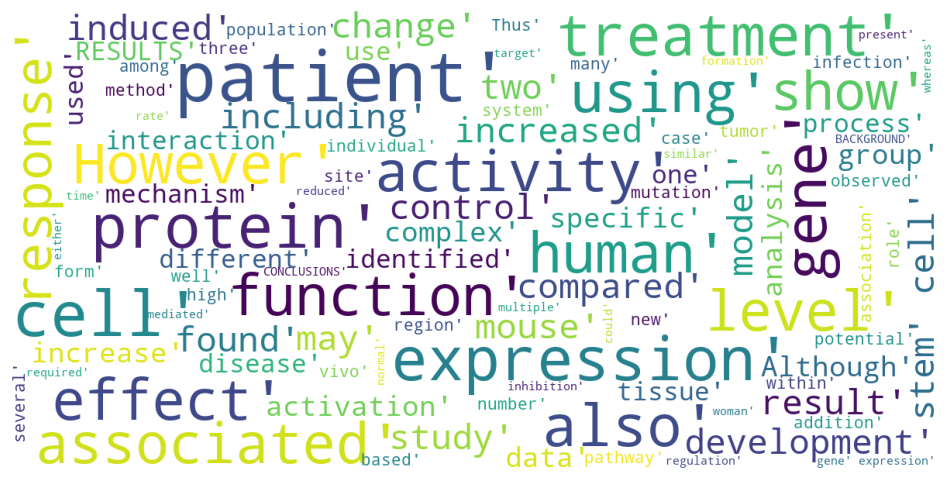

In [20]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color = 'white',
        stopwords = stopwords,
        max_words = 100,
        max_font_size = 30,
        scale = 3,
        random_state = 1)
    wordcloud = wordcloud.generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

## Sentiment analysis

Let's use two Python packages for performing sentiment analysis: [TextBlob](https://github.com/sloria/TextBlob) and [Vader Sentiment](https://github.com/cjhutto/vaderSentiment).

### TextBlob

We use the [sentiment property of the TextBlob library](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis) to calculate polarity.
Polarity ranges from -1 (negative) to 1 (positive).

A second property calculated by the sentiment property is subjectivity.
This measure ranges from 0 (objective) to 1 (subjective).

<Axes: >

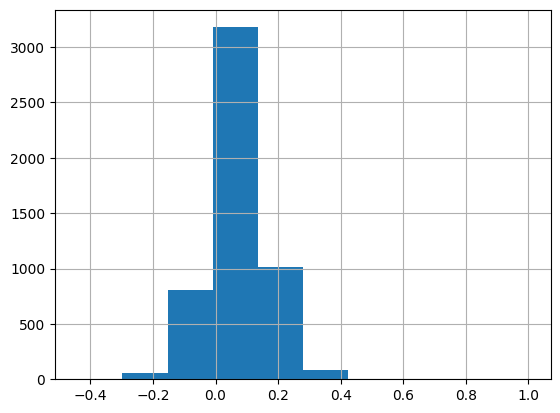

In [21]:
from textblob import TextBlob

polarity_score = abstracts.apply(lambda x: TextBlob(x).sentiment.polarity)
polarity_score.hist()

Let's use the polarity scores to classify the abstracts as Negative, Neutral, or Positive.

<BarContainer object of 3 artists>

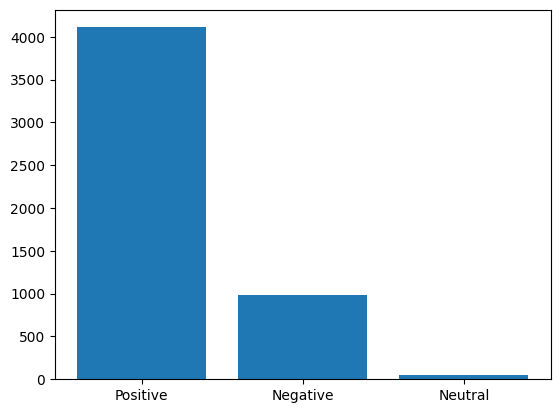

In [22]:
def sentiment(x):
    if x<0:
        return 'Negative'
    elif x==0:
        return 'Neutral'
    else:
        return 'Positive'

polarity = polarity_score. map(lambda x: sentiment(x))

plt.bar(polarity.value_counts().index, polarity.value_counts())

Print some of the positive and negative abstracts.

In [23]:
abstracts[polarity=='Positive'].head()

0    Alterations of the architecture of cerebral white matter in the developing human brain can affec...
1    Myelodysplastic syndromes (MDS) are age-dependent stem cell malignancies that share biological f...
2    ID elements are short interspersed elements (SINEs) found in high copy number in many rodent gen...
3    DNA methylation plays an important role in biological processes in human health and disease. Rec...
4    Two human Golli (for gene expressed in the oligodendrocyte lineage)-MBP (for myelin basic protei...
Name: abstract, dtype: object

In [24]:
abstracts[polarity=='Negative'].head()

5     Glioblastomas are deadly cancers that display a functional cellular hierarchy maintained by self...
8     Summary. We consider the problem of comparing complex hierarchical models in which the number of...
14    Hematopoietic stem cells (HSCs) develop during embryogenesis in a complex process that involves ...
22    Obesity is associated with an increased risk of developing insulin resistance and type 2 diabete...
24    It is thought that the H19 imprinting control region (ICR) directs the silencing of the maternal...
Name: abstract, dtype: object

### VADER

VADER or Valence Aware Dictionary and Sentiment Reasoner analyzes sentiments in social media based on a lexicon and set of rules.

**NOTE:** The function returns proportional values for `neg`, `neu`, `pos` that sum to 1.
The [original post](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools) simply took the highest one of these values to make the classification.
However, the `compound` score is more sensitive as [mentioned on this page](https://digitalenvironment.org/natural-language-processing-vader-sentiment-analysis-with-nltk/).

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jedick/.local/lib/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<BarContainer object of 3 artists>

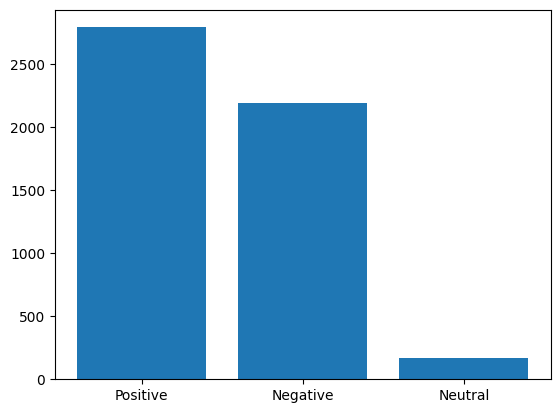

In [25]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

def get_vader_polarity(sent):
    ss = sid.polarity_scores(sent)
    # Use compound score to classify polarity
    # Recommended values from
    # https://digitalenvironment.org/natural-language-processing-vader-sentiment-analysis-with-nltk
    if ss['compound'] <= -0.05:
        return 'Negative'
    elif ss['compound'] >= 0.05:
        return 'Positive'
    else:
        return 'Neutral'

polarity = abstracts.map(lambda x: get_vader_polarity(x))
plt.bar(polarity.value_counts().index, polarity.value_counts())

## Named entity recognition

Let's perform NER using the `en_core_web_sm` model in spaCy.

```
python -m spacy download en_core_web_sm
```

After initializing the model with the nlp() function, we can visualize NER for a single abstract using the displacy module.

In [26]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm')

doc = nlp(abstracts[99])
displacy.render(doc, style = 'ent')

/home/jedick/.local/lib/python3.12/site-packages/spacy/displacy/__init__.py:69: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import HTML, display


This counts the types of entities in all the abstracts.

In [27]:
def ner(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

ent = abstracts.apply(lambda x : ner(x))
ent = [x for sub in ent for x in sub]

counter = Counter(ent)
count = counter.most_common()

Plot the frequencies of named entities.

<Axes: >

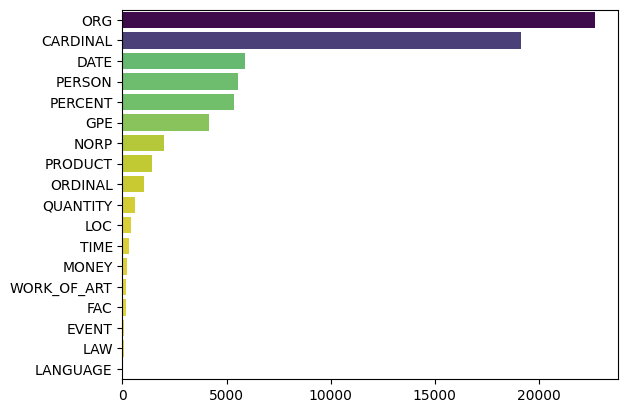

In [28]:
x, y = map(list, zip(*count))
sns.barplot(x=y, y=x, palette=viridis_rev, hue=y, legend=False)

Visualize the most common tokens for the ORG (organization) entity.

<Axes: >

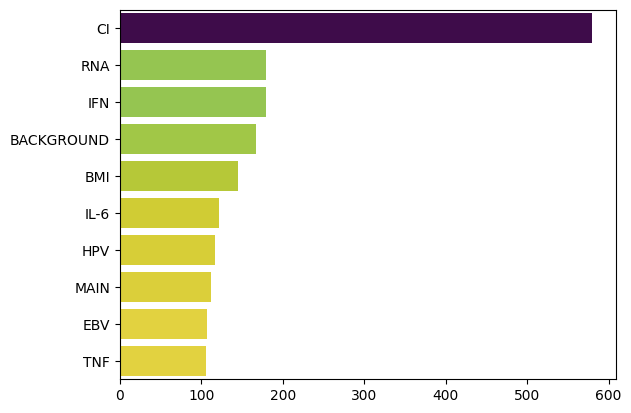

In [29]:
def ner(text, ent="ORG"):
    doc = nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

gpe = abstracts.apply(lambda x: ner(x))
gpe = [i for x in gpe for i in x]
counter = Counter(gpe)

x, y = map(list, zip(*counter.most_common(10)))
sns.barplot(x=y, y=x, palette=viridis_rev, hue=y, legend=False)

Visualize the most common tokens for the PERSON entity.

<Axes: >

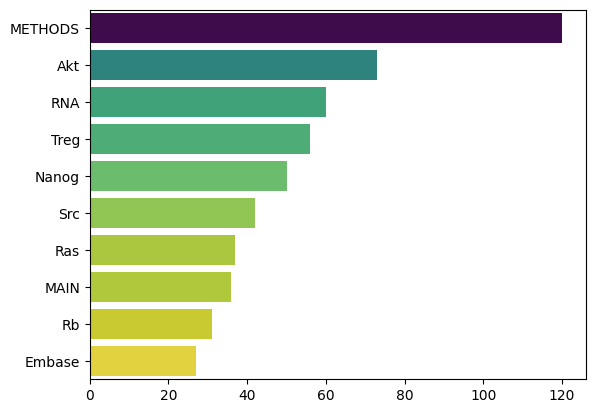

In [30]:
per = abstracts.apply(lambda x: ner(x, 'PERSON'))
per = [i for x in per for i in x]
counter = Counter(per)

x, y = map(list, zip(*counter.most_common(10)))
sns.barplot(x=y, y=x, palette=viridis_rev, hue=y, legend=False)

## Parts of speech

Let's use NLTK for parts-of-speech tagging.

<Axes: >

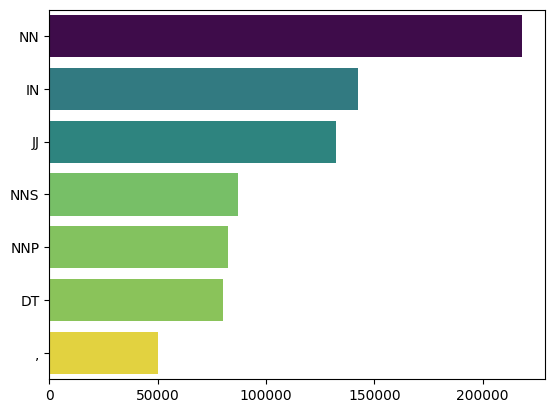

In [31]:
import nltk
from nltk.tokenize import word_tokenize

def pos(text):
    pos = nltk.pos_tag(word_tokenize(text))
    pos = list(map(list, zip(*pos)))[1]
    return pos

tags = abstracts.apply(lambda x: pos(x))
tags = [x for l in tags for x in l]
counter = Counter(tags)

x, y = list(map(list, zip(*counter.most_common(7))))
sns.barplot(x=y, y=x, palette=viridis_rev, hue=y, legend=False)

The three most frequent part of speech are noun (NN), preposition (IN), and adjective (JJ).

Visualize the most common singular nouns (NN) in the abstracts.

<Axes: >

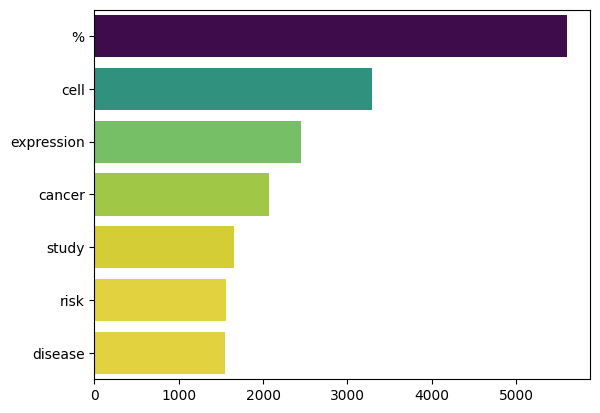

In [32]:
def get_nouns(text):
    noun = []
    pos = nltk.pos_tag(word_tokenize(text))
    for word, tag in pos:
        if tag=='NN':
            noun.append(word)
    return noun

words = abstracts.apply(lambda x: get_nouns(x))
words = [x for l in words for x in l]
counter = Counter(words)

x, y = list(map(list, zip(*counter.most_common(7))))
sns.barplot(x=y, y=x, palette=viridis_rev, hue=y, legend=False)

## Text complexity

**Flesch Reading Ease (FRE)** is one of many formulas for calculating readability of English text.
Material that is easier to read has higher FRE scores.
- FRE = 206.835 − 1.015 * (total words/total sentences) − 84.6 * (total syllables/total words)
- College level: 0-30
- High school level: 50-60
- Fourth grade level: 60+

Let’s visualize FRE scores calculated with the [Textstat](https://github.com/shivam5992/textstat) library.

/home/jedick/.local/lib/python3.12/site-packages/textstat/textstat.py:7: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/usr/lib/python3.12/site-packages/pkg_resources/__init__.py:3149: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/lib/python3.12/site-packages/pkg_resources/__init__.py:3149: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)


<Axes: >

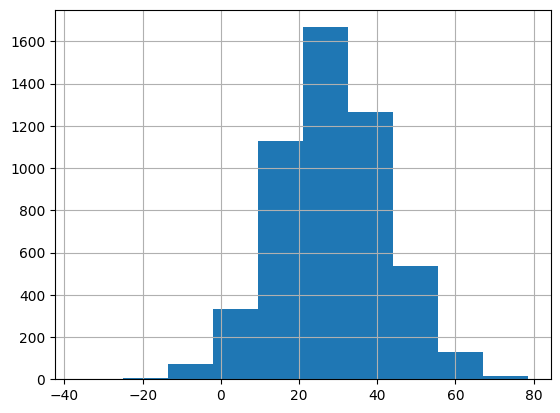

In [33]:
from textstat import flesch_reading_ease

fre = abstracts.apply(lambda x: flesch_reading_ease(x))
fre.hist()

Most of the readability scores are less than 50.
This means that an average high school student **would have trouble reading** the abstracts.
Some abstracts have scores less than 0, indicating low readability even for college students.

Let's print the harder-to-read abstracts: those with a readability score below -10.

In [34]:
abstracts[fre < -10]

335     Stem cell decline is an important cellular driver of aging-associated pathophysiology in multipl...
738     Non-alcoholic fatty liver disease (NAFLD) is the hepatic manifestation of metabolic syndrome and...
801     An inflammatory response initiated by the NLRP3 inflammasome is triggered by a variety of situat...
1183    The inborn errors of heme biosynthesis, the porphyrias, are 8 genetically distinct metabolic dis...
1490    Optogenetic technologies employ light to control biological processes within targeted cells in v...
2257    Nitrite (NO(2)(-)), previously viewed as a physiologically inert metabolite and biomarker of the...
2347    Differentiating somatic cells are progressively restricted to specialized functions during ontog...
2629    Receptor tyrosine kinases are involved in regulation of key processes in endothelial biology, in...
2829    Higher-order chromosomal organization for transcription regulation is poorly understood in eukar...
3575    Since 2008 the World

Let's print the easier-to-read abstracts: those with a readability score above 70.

In [35]:
abstracts[fre > 70]

243     To assess the age- and sex-specific prevalence of peripheral arterial disease (PAD) and intermit...
3561    AIMS A recent genome-wide association study identified a haplotype block on chromosome 4q25 asso...
3614    Background: The prevalence of multiple sclerosis (MS) shows considerable variability all over th...
4614    BACKGROUND Transcranial contrast Doppler studies have shown an increased prevalence of right-to-...
5105    Researches on the cultivation of the parasites of malaria in Liverpool were commenced some time ...
Name: abstract, dtype: object

# Key takeaways
- Most of the abstracts have between 100 and 300 words.
- The main topics are related to gene expression, cancer, treatment, and infection.
- CI (an abbreviation for confidence interval) appears commonly in the abstracts, as does METHODS (a heading in abstracts).
    - The implementation of NER here is not accurate regarding the types of entities.
- VADER classifies approximately slightly more abstracts as positive than negative, as opposed to mainly positive classifications by TextBlob.
    - Sentiment modeling is typically used for news and social media and may not provide great insight into scientific abstracts.
- Readability for most abstracts is at the college level.